In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.lines as mlines
import json
from scipy.spatial import distance_matrix

# === Problem Setup ===

# # 3 drones
# num_drones = 3
# drone_starts = {
#     'd0': (0, 0),
#     'd1': (10, 0),
#     'd2': (5, 5)
# }
# # 3 tasks
# num_tasks = num_drones
# task_locations = {
#     't0': (2, 10),
#     't1': (3, 7),
#     't2': (9, 1)
# }

# Load drone starts from a JSON file
with open("./drone_starts.json", "r") as f:
    drone_starts = json.load(f)

# Convert string keys to tuples if needed
drone_starts = {k: tuple(v) for k, v in drone_starts.items()}
num_drones = len(drone_starts)


# Load task locations from a JSON file
with open("./task_locations.json", "r") as f:
    task_locations = json.load(f)

# Convert string keys to tuples if needed
task_locations = {k: tuple(v) for k, v in task_locations.items()}
num_tasks = len(task_locations)


# Combine all nodes
all_nodes = list(drone_starts.keys()) + list(task_locations.keys())
locations = {**drone_starts, **task_locations}

print("All Nodes and Locations:")
for node, loc in locations.items():
    print(f"{node}: ({loc[0]:.2f}, {loc[1]:.2f})")

# Create index mapping for distance matrix
node_indices = {node: i for i, node in enumerate(all_nodes)}
coords = [locations[node] for node in all_nodes]

# Distance matrix
dist_matrix = distance_matrix(coords, coords)

# Bid matrix
bid_matrix = np.ones((num_drones,num_tasks))  # Initialize with ones
bid_matrix = 1/((bid_matrix) * dist_matrix[:num_drones,num_drones:])  # Scale by distances

# Create a DataFrame for the distance matrix
distance_df = pd.DataFrame(dist_matrix, index=all_nodes, columns=all_nodes)
print("\n=== Distance Matrix (Euclidean distances) ===")
print(distance_df.round(2))  # Rounded to 2 decimal places

All Nodes and Locations:
d0: (0.32, 14.67)
d1: (10.85, 11.67)
d2: (13.26, 13.19)
d3: (1.33, 14.54)
d4: (7.15, 10.36)
t0: (14.51, 0.60)
t1: (9.79, 2.10)
t2: (3.74, 13.41)
t3: (11.34, 14.92)
t4: (1.97, 4.32)

=== Distance Matrix (Euclidean distances) ===
       d0     d1     d2     d3     d4     t0     t1     t2     t3     t4
d0   0.00  10.95  13.02   1.02   8.08  19.99  15.74   3.65  11.02  10.48
d1  10.95   0.00   2.85   9.94   3.92  11.66   9.63   7.32   3.28  11.52
d2  13.02   2.85   0.00  12.00   6.73  12.65  11.62   9.52   2.58  14.35
d3   1.02   9.94  12.00   0.00   7.16  19.18  15.04   2.66  10.01  10.24
d4   8.08   3.92   6.73   7.16   0.00  12.23   8.67   4.58   6.19   7.95
t0  19.99  11.66  12.65  19.18  12.23   0.00   4.96  16.74  14.67  13.08
t1  15.74   9.63  11.62  15.04   8.67   4.96   0.00  12.83  12.91   8.13
t2   3.65   7.32   9.52   2.66   4.58  16.74  12.83   0.00   7.75   9.26
t3  11.02   3.28   2.58  10.01   6.19  14.67  12.91   7.75   0.00  14.14
t4  10.48  11.52 

In [26]:
# Communication Graph Functions

def fully_connected(num_drones):
    return np.ones((num_drones,num_drones))


def is_connected(G: np.ndarray) -> bool:
    """
    Return True if the undirected graph represented by adjacency matrix G is connected,
    False otherwise. G may include self-loops (ignored).
    """
    A = np.asarray(G, dtype=bool)
    n = A.shape[0]
    if n <= 1:
        return True

    
    A = A | A.T
    np.fill_diagonal(A, False)


    if n > 1 and np.any(A.sum(axis=1) == 0):
        return False

    # DFS from node 0
    visited = np.zeros(n, dtype=bool)
    stack = [0]
    while stack:
        v = stack.pop()
        if visited[v]:
            continue
        visited[v] = True
        neighbors = np.flatnonzero(A[v])
        # push unvisited neighbors
        for u in neighbors:
            if not visited[u]:
                stack.append(u)

    return visited.all()


# Finds the minimum communication range to still have a connected graph
def min_comm_range(dist_matrix, num_drones):
    comm_range = np.max(dist_matrix)

    G = (dist_matrix[:num_drones,:num_drones]< comm_range).astype(int)

    still_connected = is_connected(G)

    while still_connected:
        comm_range -= 0.1
        G = (dist_matrix[:num_drones,:num_drones]< comm_range).astype(int)
        still_connected = is_connected(G)

    comm_range += 0.1

    print(comm_range)
    G = (dist_matrix[:num_drones,:num_drones]< comm_range).astype(int)
    print(is_connected(G))

    return G, comm_range


def plot_comm_graph(drone_starts, comm_range):
    
    drones = list(drone_starts.keys())

    # === Plot setup ===
    plt.figure(figsize=(10, 8))
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)
    ax = plt.gca()

    # Collect positions for autoscaling later
    xy = np.array([drone_starts[d] for d in drones])
    xs, ys = xy[:,0], xy[:,1]

    # Plot drones
    for i, d in enumerate(drones):
        x_pos, y_pos = drone_starts[d]
        plt.scatter(x_pos, y_pos, c='blue', marker='^', s=150, label="Robot" if i == 0 else "")
        plt.text(x_pos + 0.2, y_pos + 0.2, f"r{i}", fontsize=16)

        # Communication range circle (red outline)
        circ = Circle((x_pos, y_pos), comm_range, fill=False, edgecolor='red', linewidth=1.8, alpha=0.8)
        ax.add_patch(circ)

    # Nice viewing area (pad so whole circles are visible)
    pad = comm_range + 1
    ax.set_xlim(xs.min() - pad, xs.max() + pad)
    ax.set_ylim(ys.min() - pad, ys.max() + pad)

    # Legend (add a proxy for the red circles)
    range_proxy = mlines.Line2D([], [], color='red', linestyle='-', label='Comm range')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles + [range_proxy], labels + ['Comm range'], loc='best', fontsize=16)

    # Draw edges for pairs within communication range
    for i, di in enumerate(drones):
        xi, yi = drone_starts[di]
        for j in range(i+1, len(drones)):
            dj = drones[j]
            xj, yj = drone_starts[dj]
            if np.hypot(xi - xj, yi - yj) <= comm_range:
                plt.plot([xi, xj], [yi, yj], linewidth=1.2, alpha=0.6)


    plt.grid(True)
    plt.axis('equal')
    plt.tick_params(axis='both', labelsize=12)
    plt.title("Drone Locations", fontsize=18)
    plt.tight_layout()
    plt.show()



In [27]:
# Consensus-Based Auction Algorithm (CBAA)
X = np.zeros((num_drones,num_tasks))
Y = np.zeros((num_drones,num_tasks))
J = np.zeros(num_drones)


# Selecting fully connected communication graph
G = fully_connected(num_drones)

X_list = []
Y_list = []
Total_distance_list = []
counter = 0

# CBAA
while (counter < 100):
    X_prev = X.copy()

    # Algorithm 1
    for i in range(num_drones):
        if np.sum(X[i]) == 0:
            
            c_i = bid_matrix[i]  # bid (either inverse cost or reward value) for drone i
            h_i = (c_i>Y[i]).astype(int)  # h_i is 1 if bid is greater than Y[i], else 0

            # If there are any attainable tasks
            if h_i.any() != 0:
                valid_bids = c_i * h_i  # Only consider bids where h_i is 1
 
                J[i] = np.argmax(valid_bids) # index of task with highest bid for drone i 
                       
                J_i = int(J[i])
                X[i, J_i] = 1           # Assign task J_i to self
                Y[i,J_i] = c_i[J_i]     # Place bid c_{i,J_i} 

    Y_send = Y.copy()

    # Algorithm 2
    for i in range(num_drones):
        J_i = int(J[i])

        not_uniform = np.any(Y[G[i]==1,J_i] != Y[G[i]==1,J_i].flat[0])
        if not not_uniform:
            continue  # Skip if all Y values for task J_i are the same (no updates)

        Y_copy = Y_send.copy()
        Y_copy[G[i]==0,J_i] = 0  # Neglecting Y values of drones not in the communication range

        z_i_J_i = np.argmax(Y_copy[:,J_i])  # Find the drone with the maximum Y value for task J_i

        # Release chosen task if not the highest bid
        if z_i_J_i != i:
            X[i, J_i] = 0

    
    # Updating Y values based on max from neighbors
    for i in range(num_drones):
        for j in range(num_tasks):
            Y[i, j] = max(Y_send[G[i]==1, j])    # Update Y[i,j] with max from neighbors


    # Exiting condition
    if np.sum(X) == num_tasks:
        all_assigned = True
        for j in range(num_tasks):
            if np.sum(X[:,j]) == 0:     # Do not exit if any task j is not assigned
                all_assigned = False
                break
        if all_assigned:
            if not np.array_equal(X, X_prev):   
                # Do not exit if X is not equal to X_prev (might not have converged yet)
                counter += 1
                X_list.append(X.copy())
                total_distance = np.sum(X * dist_matrix[:num_drones, num_drones:])
                Total_distance_list.append(total_distance)
                continue
            print("All tasks assigned.")
            break

    # Saving algorithm step information
    counter += 1
    X_list.append(X.copy())
    total_distance = np.sum(X * dist_matrix[:num_drones, num_drones:])
    Total_distance_list.append(total_distance)


# Print final assignments
print("\n=== Final Assignments ===")
print(X)
print(counter, "iterations")

total_distance = np.sum(X * dist_matrix[:num_drones, num_drones:])
print("\n=== Total Distance for Assignments ===")
print(total_distance)
    

All tasks assigned.

=== Final Assignments ===
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
3 iterations

=== Total Distance for Assignments ===
42.80558697104743


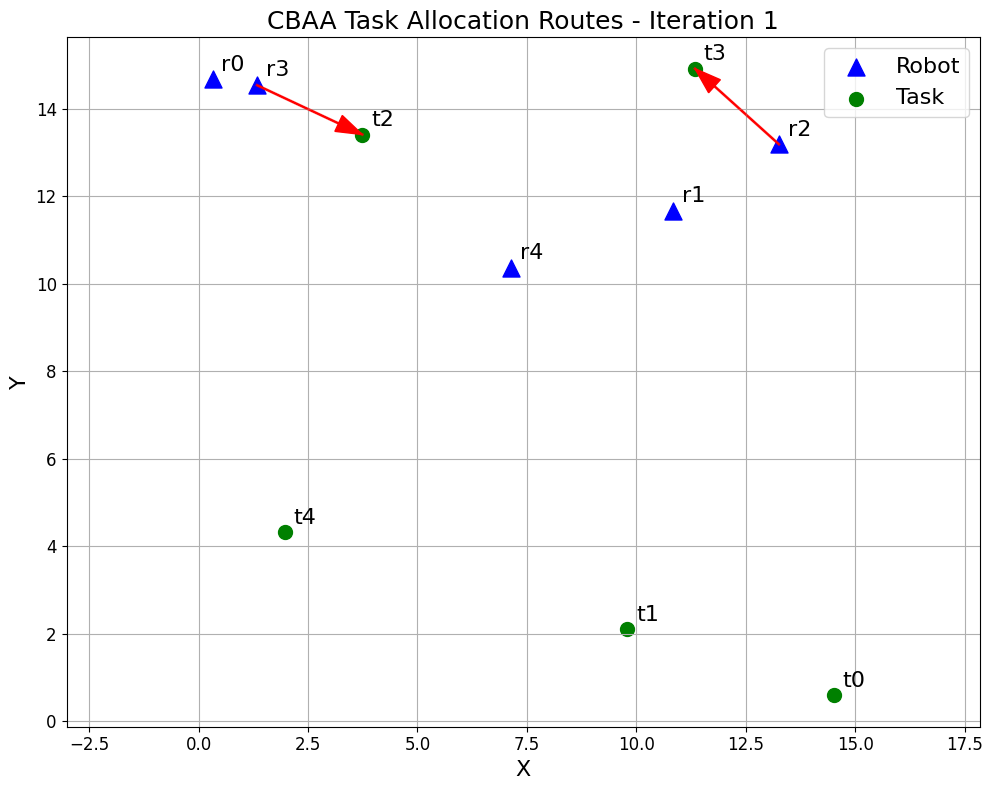

=== Total Distance at Iteration 1: 5.24




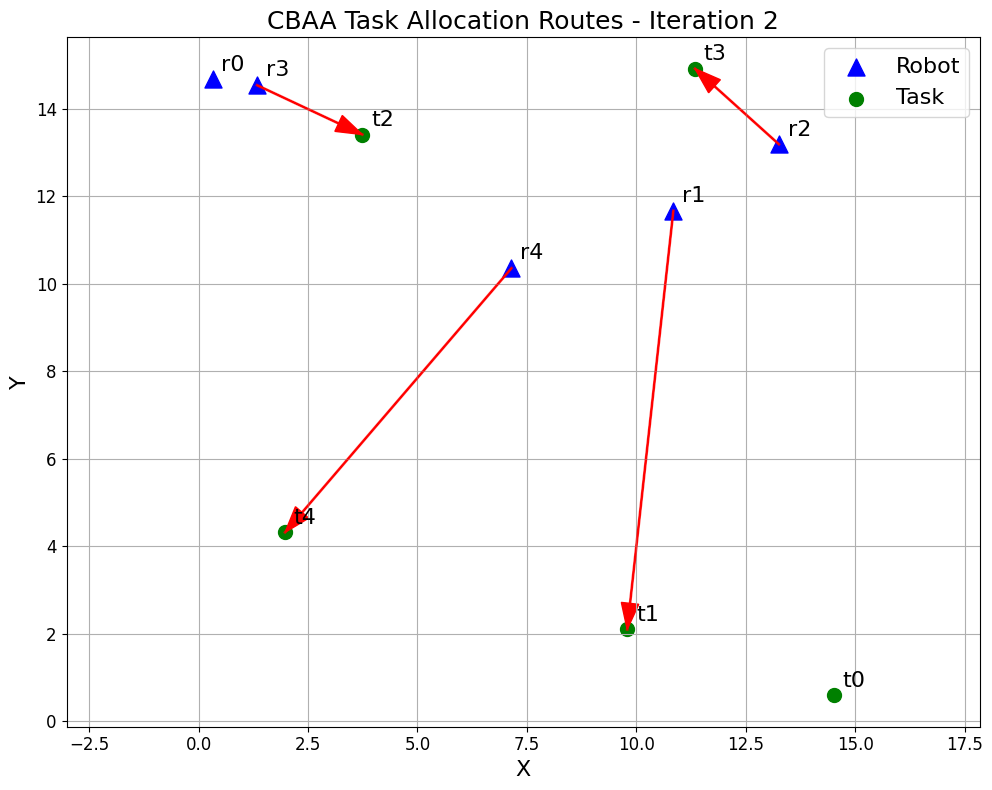

=== Total Distance at Iteration 2: 22.82




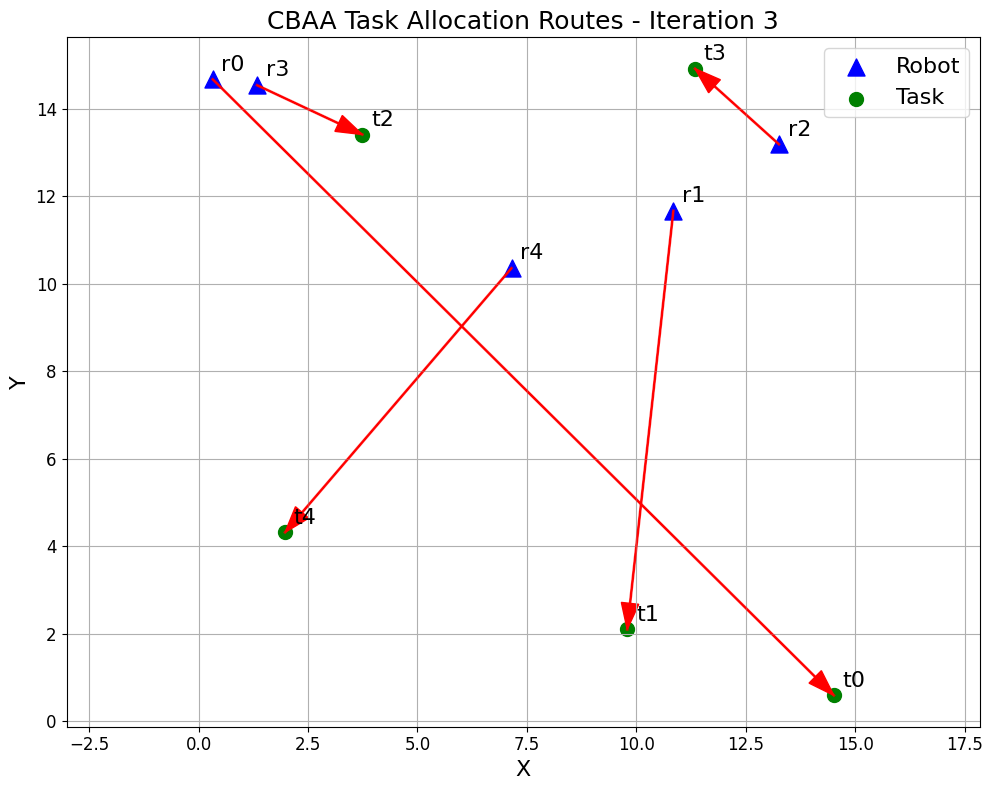

=== Total Distance at Iteration 3: 42.81




In [28]:
tasks = list(task_locations.keys())
drones = list(drone_starts.keys())

# === Extract positions ===
drone_positions = [locations[d] for d in drones]
task_positions = [locations[t] for t in tasks]

print_interval = 1  # Plot every n iterations

for step, X_step in enumerate(X_list):
    if step == len(X_list)-1:
        pass
    elif step % print_interval != 0:
        continue


    # === Plot setup ===
    plt.figure(figsize=(10, 8))
    # plt.title("CBAA Task Allocation Routes")
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)

    # Plot drones
    for i, d in enumerate(drones):
        x_pos, y_pos = locations[d]
        plt.scatter(x_pos, y_pos, c='blue', marker='^', s=150, label="Robot" if i == 0 else "")
        plt.text(x_pos + 0.2, y_pos + 0.2, "r"+str(i), fontsize=16)

    # Plot tasks
    for i, t in enumerate(tasks):
        x_pos, y_pos = locations[t]
        plt.scatter(x_pos, y_pos, c='green', marker='o', s=100, label="Task" if i == 0 else "")
        plt.text(x_pos + 0.2, y_pos + 0.2, t, fontsize=16)

    # === Plot paths based on X array ===
    for i in range(len(drones)):
        for j in range(len(tasks)):
            if X_step[i, j] > 0.5:
                start = drones[i]
                end = tasks[j]
                x_coords = [locations[start][0], locations[end][0]]
                y_coords = [locations[start][1], locations[end][1]]
                plt.plot(x_coords, y_coords, 'r-', linewidth=2, alpha=0.7)
                plt.arrow(
                    x_coords[0], y_coords[0],
                    x_coords[1] - x_coords[0],
                    y_coords[1] - y_coords[0],
                    head_width=0.4, head_length=0.6, fc='red', ec='red', length_includes_head=True
                )

    # === Finalize plot ===
    plt.legend(loc='best', fontsize=16)
    plt.grid(True)
    plt.axis('equal')
    plt.tick_params(axis='both', labelsize=12)
    plt.title(f"CBAA Task Allocation Routes - Iteration {step+1}", fontsize=18)
    plt.tight_layout()
    plt.show()
    print(f"=== Total Distance at Iteration {step+1}: {Total_distance_list[step]:.2f}\n\n")
